In [1]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
from urllib import request, parse
from copy import deepcopy
from typing import List
from dataclasses import dataclass, field
import networkx as nx
import matplotlib.cm as cm
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap as Basemap
from fa2 import ForceAtlas2
import seaborn as sns
from networkx.algorithms import community
import json
import pandas as pd
from tqdm import tqdm
from thefuzz import process
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler
#import swifter
#import dask
import pycountry
import nltk
from nltk.corpus import stopwords
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


requests.packages.urllib3.util.connection.HAS_IPV6 = False

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Functions

In [2]:
def get_wiki_page(page):
    resp = requests.get(f'https://en.wikipedia.org/api/rest_v1/page/html/{parse.quote(page)}?redirect=false&stash=false')

    if resp.status_code == 200:
        return resp.text
    else:
        return ''

In [3]:
def remove_tags(html):
  
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
  
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
  
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)

In [4]:
def populate_graph(G, Teams,criterion = None):
    for team in Teams:
        if criterion is not None:
            if team.country != criterion:
                continue
        G.add_node(team.name, data=team)
        for c in team.get_connections():
            G.add_edge(team.name, c)

In [5]:
def get_city(id):
    res = requests.get(f'https://en.soccerwiki.org/squad.php?clubid={id}')
    html = BeautifulSoup(res.text)
    return html.findAll('p', {'class': 'player-info-subtitle'})[7].text.split(': ')[-1]

In [6]:
def get_location(city,country):
    resp = requests.get(f'http://api.openweathermap.org/geo/1.0/direct?q={city},{country}&limit=5&appid=###')
    try:
        response_json = resp.json()[0]
        return response_json['lat'], response_json['lon']
    except:
        return None
    

In [7]:
def get_table(season, country, url):
    r = requests.get(url.replace('year1', str(season[0])).replace('year2', str(season[1])))
    if r.status_code == 200:
        try:
            df_league = pd.read_html(r.text)[3]
            df_league['season'] = season[0]
            df_league['country'] = country
            return df_league
        except IndexError:
            return None
    else:
        return None

In [8]:
def fit_ols(df):
    lr = OLS.from_formula('Placement ~ in_degree', data = df)
    res = lr.fit()
    return lr, res

In [9]:
def get_sentiment(corpus):
    
    words = map(str.lower, corpus)
    words = [w for w in words if w not in stopwords]
    df_words = set(chosen_words_sentiment.word.values)

    valid_words = [w for w in words if w in df_words]
    if len(valid_words) > 10:
        score = np.array(list(map(sentiment_dict.get, valid_words))).mean()
        return score
    
    return np.nan

In [10]:
def get_sentiment_stats():
    plt.bar(corpuses.keys(), list(map(get_sentiment, corpuses.values())))
    plt.ylim(6, 7.5)
    plt.xticks(rotation = 90)
    plt.show()

    sentiment_df = pd.DataFrame(dict(zip(corpuses.keys(),list(map(get_sentiment, corpuses.values())))), index = [0]).T.reset_index()
    sentiment_df.columns = ["Team", "SentimentScore"]
    sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")
    sentiment_df.Team = sentiment_df.Team.str.replace(" ", "")


    df_england.Team = df_england.Team.str.replace("FC", "")
    df_england.Team = df_england.Team.str.replace(" ", "")

    df_sentiment_regression = pd.merge(sentiment_df, df_england, right_on="Team", left_on="Team")[['Team', 'SentimentScore', "Placement"]]

    sc = StandardScaler()
    data = sc.fit_transform(df_sentiment_regression[['SentimentScore', "Placement"]]).T
    X, y = data[0], data[1]
    lr_sentiment = LinearRegression()
    lr_sentiment.fit(X.reshape(-1,1), y)

    print(f'R2 = {lr_sentiment.score(X.reshape(-1,1), y)}')
    print(f'Coef = {lr_sentiment.coef_}')
    print(f'Intercept = {lr_sentiment.intercept_}')

    identity = np.linspace(-1.5,1.5, 100)
    plt.scatter(y, lr_sentiment.predict(X.reshape(-1,1)))
    plt.plot(identity,identity, color = 'red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. predicted')
    plt.show()


    plt.plot(X, lr_sentiment.predict(X.reshape(-1,1)), color = 'red', label = 'prediction')
    plt.scatter(X, y, label = 'actual')
    plt.legend()
    plt.show()

# Class

In [11]:
@dataclass
class Team:
    name: str
    country: str
    no_words: int
    words: List[str]
    connections: List = field(default_factory=list)
    
    
    def add_connection(self, name):
        self.connections.append(name)
    
    def get_connections(self):
        return self.connections
    
    def __repr__(self):
        return f'Name: {self.name}'

# Reading data

The code block below gets teamnames, Wikilinks and country of all European clubs

In [12]:
# r = requests.get('https://en.wikipedia.org/wiki/List_of_top-division_football_clubs_in_UEFA_countries')
# html = r.text
# bs = BeautifulSoup(html)
# wikitables = bs.findAll("table",{"class":"wikitable"})
# h3s = bs.findAll("h3")
# countries = {}
# idx = 0
# for h3 in h3s:
#     try:
#         name = h3.find('span').text
#         if name in ['San Marino', 'Slovakia']:
#             continue
#         countries[idx] = name
#         idx += 1
#     except:
#         continue
# countries = pd.DataFrame(countries, index=[0]).T
# countries.columns = ['Country']
# countries = countries[:-8]
# teams = {}
# idx = 0

# for table in wikitables:
#     increment = True
#     for team in table.findAll('a')[3:]:
#         try:
#             name = team['title']
#             if len(re.findall('\d+', name)) != 0:
#                 continue
#             link = team['href']
#             if teams.get(name, None) is None:
#                 teams[name] = [link, idx]
#                 increment = True
#             else:
#                 increment = False
#         except:
#             increment = False
    
#     if increment:
#         idx += 1
# df = pd.DataFrame(teams).T.reset_index()
# df.columns = ['TeamName', 'Link', 'idx']
# df = df.drop_duplicates('TeamName')
# map_idx = dict(zip(list(df.idx.unique()), [i for i in range(len(df.idx.unique()))]))
# df = pd.merge(df, countries, left_on='idx', right_index=True)
# df = df[['TeamName', 'Link', 'Country']]
# df.to_csv('teams.csv')

In [13]:
df = pd.read_csv("data/teams.csv", index_col=[0])

In [14]:
new_links = []
for i in range(df.shape[0]):
    if ("(page does not exist)" in df.TeamName[i]):
        new_links.append("No page")
        continue
    new_links.append(df.Link[i].split("/wiki/")[1])

In [15]:
df["Link"] = new_links

## Finding connections

In [16]:
Teams = []
for idx, row in tqdm(df.iterrows()):
    name = row[0]
    country = row[2]
    html = get_wiki_page(row[1])
    html_2 = deepcopy(html)
    connections = []
    for link in BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a')):
        if not link.has_attr('href'):
            continue
        if not link['href'].replace('./', '') in df.Link.to_list():
            continue
        
        connections.append(df[df['Link'] == link['href'].replace('./', '')].TeamName.values[0])
    
    words = remove_tags(html).split()
    current_team = Team(name, country, len(words), words)
    current_team.connections = connections
    Teams.append(current_team)

672it [04:08,  2.71it/s]


In [17]:
Teams = []
for idx, row in tqdm(df.iterrows()):
    name = row[0]
    country = row[2]
    html = get_wiki_page(row[1])
    html_2 = deepcopy(html)
    connections = []
    for link in BeautifulSoup(html, 'html.parser', parse_only=SoupStrainer('a')):
        if link.has_attr('href'):
            if link['href'].replace('./', '') in df.Link.to_list():
                connections.append(df[df['Link'] == link['href'].replace('./', '')].TeamName.values[0])
    
    words = remove_tags(html).split()
    current_team = Team(name, country, len(words), words)
    current_team.connections = connections
    Teams.append(current_team)

672it [03:51,  2.91it/s]


## Getting the city each club is located in (Can't be run because of API key, but data provided in cell below)

In [18]:
# with open('SoccerWiki_2022-11-16 - Club Data - League Data - Stadium Data_1668583927.json', 'r') as f:
#     json_data = json.loads(f.read())
# df_clubs = pd.DataFrame(json_data['ClubData'])
# dask_df = dask.dataframe.from_pandas(df, npartitions=5)
# clubs = df_clubs['Name'].values
# dask_df['club_id'] = dask_df.apply(lambda x: process.extractOne(x.TeamName, clubs)[0], axis=1)
# dask_df = dask_df.compute()
# df_latlon = pd.merge(dask_df, df_clubs[['ID', 'Name']], left_on='club_id', right_on='Name', how='left')
# df_latlon = df_latlon.drop(columns=['club_id'])
# tqdm.pandas()
# df_latlon['City'] = df_latlon['ID'].progress_apply(get_city)
# df_latlon['Country'][df_latlon['Country'].str.lower().isin(['england', 'republic of ireland', 'scotland', 'wales'])] = 'Great Britain'
# df_latlon['iso_obj'] = df_latlon.Country.apply(pycountry.countries.search_fuzzy)
# df_latlon['iso'] = df_latlon['iso_obj'].apply(lambda x: x[0].alpha_2)
# df_latlon['location'] = df_latlon.progress_apply(lambda x: get_location(x.City, x.iso), axis = 1)
# df_latlon = df_latlon.drop(columns=['iso_obj'])
# df_latlon = df_latlon.dropna()
# df_latlon['lat'] = df_latlon.location.apply(lambda x: x[0])
# df_latlon['lon'] = df_latlon.location.apply(lambda x: x[1])
# df_latlon = df_latlon.drop(columns=['location'])

## Reading in the data collected above

In [19]:
df_team_loc = pd.read_csv("data/teams_w_loc.csv", index_col=[0])

# Making graph

In [20]:
G = nx.DiGraph()

Connections which are dublicates or the team itself are removed.

In [21]:
for i in range(len(Teams)):
    Teams[i].connections = list(set(Teams[i].connections))
    Teams[i].connections = [ j for j in Teams[i].connections if j!=Teams[i].name]

In [22]:
populate_graph(G, Teams)

In [23]:
len(G.nodes)

672

Removing isolated nodes and nodes that we couldnt find a location for

In [24]:
G.remove_nodes_from(list(nx.isolates(G)))
G.remove_nodes_from(list(set(G.nodes).difference(set(df_team_loc.TeamName))))

In [25]:
len(G.nodes())

455

Plotting the Graph

In [26]:
cmap = cm.get_cmap('viridis', df.shape[0] + 1)

In [27]:
countries = []
for i in G.nodes():
    countries.append(G.nodes()[i].get("data").country)

In [28]:
ord_enc = OrdinalEncoder()
c_list = ord_enc.fit_transform(np.array(countries).reshape(-1, 1))

Adding small bias to avoid circular edges

In [29]:
df_team_loc.lat = df_team_loc.lat + np.random.uniform(-0.000001,0.000001,df_team_loc.shape[0])
df_team_loc.lon = df_team_loc.lon + np.random.uniform(-0.000001,0.000001,df_team_loc.shape[0])

In [30]:
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.lat, x.lon], axis=1).to_dict()

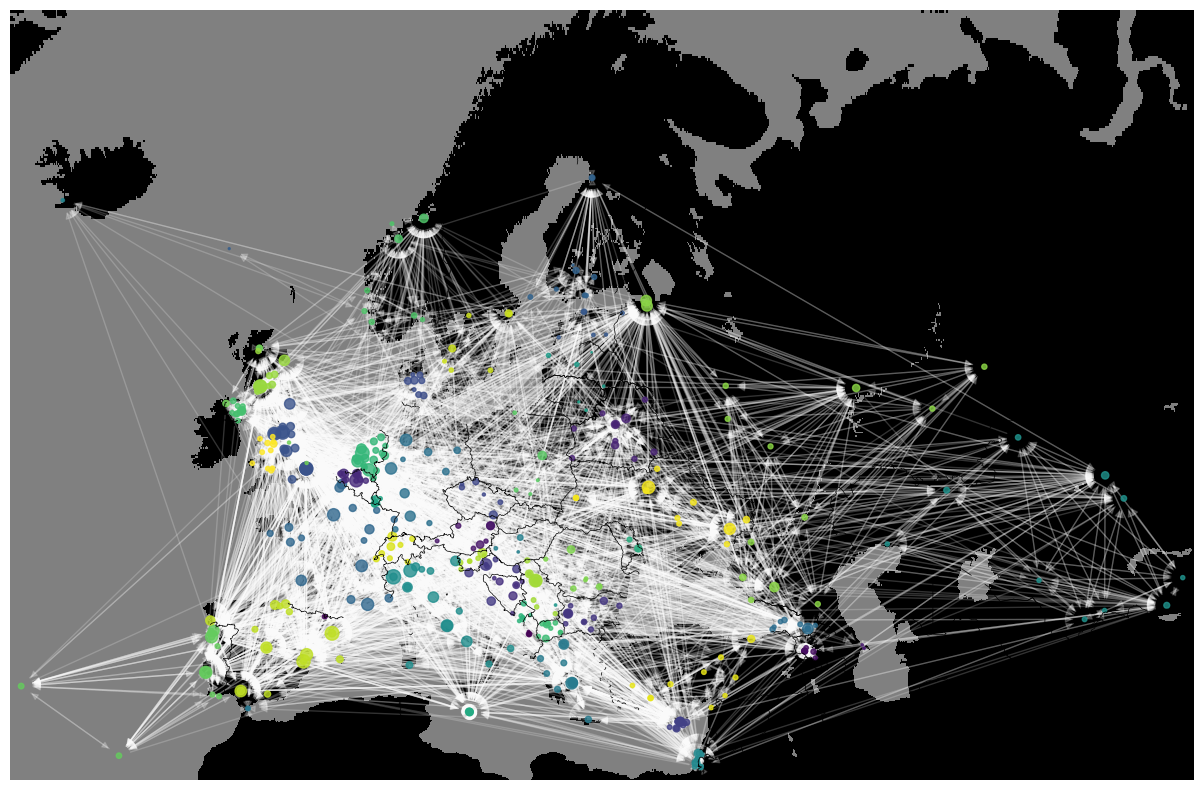

In [31]:
plt.figure(figsize=(20,10))

m = Basemap(
        projection='merc',
        llcrnrlon=df_team_loc.lon.min()-1,
        llcrnrlat=df_team_loc.lat.min()-1,
        urcrnrlon=df_team_loc.lon.max()+1,
        urcrnrlat=df_team_loc.lat.max()+1,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_team_loc.lon,df_team_loc.lat)
df_team_loc["mx"], df_team_loc["my"] = mx, my
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G, pos=pos, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

Plotting in- and out-degree distribution

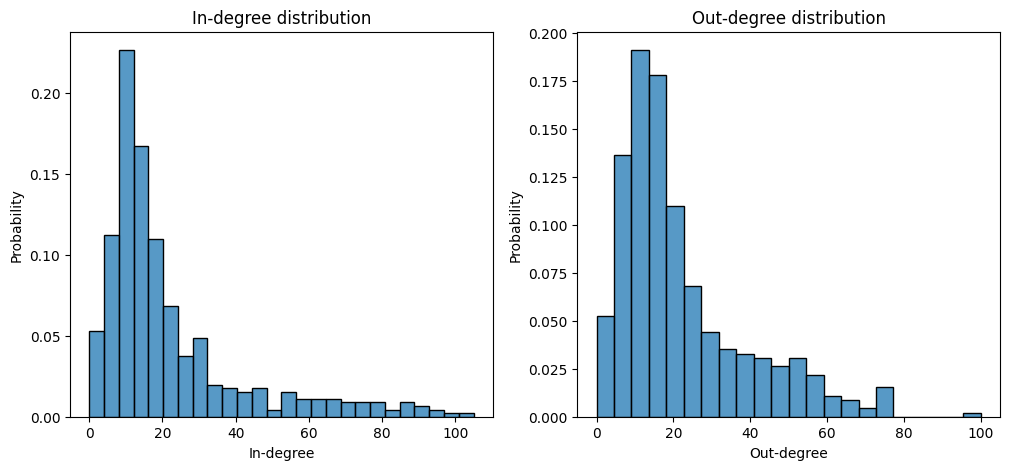

In [94]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(dict(sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True)), ax=ax[0], stat="probability")
ax[0].set_xlabel("In-degree")
ax[0].set_title("In-degree distribution")
sns.histplot(dict(sorted(dict(G.out_degree()).items(), key=lambda item: item[1], reverse=True)), ax=ax[1], stat="probability")
ax[1].set_xlabel("Out-degree")
ax[1].set_title("Out-degree distribution")
plt.show()

Seeing teams in-degree

In [33]:
dict(sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True))

{'Juventus F.C.': 105,
 'FC Barcelona': 97,
 'Manchester United F.C.': 95,
 'AFC Ajax': 94,
 'Valencia CF': 90,
 'R.S.C. Anderlecht': 89,
 'Chelsea F.C.': 89,
 'Liverpool F.C.': 87,
 'Rangers F.C.': 86,
 'A.C. Milan': 85,
 'Arsenal F.C.': 85,
 'Red Star Belgrade': 84,
 'Celtic F.C.': 84,
 'FC Dynamo Kyiv': 79,
 'PSV Eindhoven': 78,
 'S.L. Benfica': 77,
 'Paris Saint-Germain F.C.': 77,
 'Tottenham Hotspur F.C.': 76,
 'Olympique de Marseille': 75,
 'Villarreal CF': 74,
 'FC Porto': 74,
 'Feyenoord': 71,
 'S.S. Lazio': 71,
 'Olympique Lyonnais': 70,
 'Olympiacos F.C.': 69,
 'GNK Dinamo Zagreb': 68,
 'Sevilla FC': 68,
 'SV Werder Bremen': 68,
 'Borussia Dortmund': 66,
 'FK Partizan': 65,
 'West Ham United F.C.': 63,
 'FC Shakhtar Donetsk': 63,
 'Real Madrid CF': 63,
 'S.C. Braga': 62,
 'Aston Villa F.C.': 62,
 'Manchester City F.C.': 59,
 'PFC CSKA Moscow': 58,
 'FC Zenit Saint Petersburg': 58,
 'A.S. Roma': 57,
 'FC Dinamo Tbilisi': 57,
 'Aberdeen F.C.': 56,
 'S.S.C. Napoli': 56,
 'ACF Fi

Seeing teams out-degree

In [34]:
dict(sorted(dict(G.out_degree()).items(), key=lambda item: item[1], reverse=True))

{'Valencia CF': 100,
 'FC Dinamo Tbilisi': 77,
 'S.C. Braga': 77,
 'Sevilla FC': 75,
 'Legia Warsaw': 75,
 'GNK Dinamo Zagreb': 73,
 'AZ Alkmaar': 73,
 'Olympiacos F.C.': 73,
 'SK Slavia Prague': 71,
 'VfB Stuttgart': 70,
 'Juventus F.C.': 67,
 'AFC Ajax': 66,
 'FK Austria Wien': 66,
 'Villarreal CF': 66,
 'Feyenoord': 63,
 'FC BATE Borisov': 62,
 'FC Barcelona': 61,
 'FC Dynamo Kyiv': 60,
 'R.S.C. Anderlecht': 60,
 'Rangers F.C.': 59,
 'Paris Saint-Germain F.C.': 59,
 'RC Celta de Vigo': 59,
 'West Ham United F.C.': 58,
 'AC Omonia': 57,
 'Chelsea F.C.': 56,
 'Manchester United F.C.': 56,
 'AEK Athens F.C.': 55,
 'Real Madrid CF': 55,
 'Aston Villa F.C.': 55,
 'PFC CSKA Moscow': 54,
 'FK Partizan': 53,
 'A.C. Milan': 53,
 'Olympique de Marseille': 53,
 'SV Werder Bremen': 53,
 'Aberdeen F.C.': 52,
 'Borussia Dortmund': 52,
 'FC Porto': 52,
 'Linfield F.C.': 51,
 'FC Zenit Saint Petersburg': 51,
 'SK Sturm Graz': 51,
 'PSV Eindhoven': 51,
 'Olympique Lyonnais': 51,
 'K.V. Mechelen': 51

## Summary statistics

## Trying to plot with Force-Atlas2 layout

In [35]:
forceatlas2 = ForceAtlas2(
                    # Behavior alternatives
                    outboundAttractionDistribution=False,  # Dissuade hubs
                    linLogMode=False,  # NOT IMPLEMENTED
                    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                    edgeWeightInfluence=0.0,

                    # Performance
                    jitterTolerance=1.0,  # Tolerance
                    barnesHutOptimize=False,
                    barnesHutTheta=1.2,
                    multiThreaded=False,  # NOT IMPLEMENTED

                    # Tuning
                    scalingRatio=2.0,
                    strongGravityMode=True,
                    gravity=1.0,

                    # Log
                    verbose=True)

pos_FA = forceatlas2.forceatlas2_networkx_layout(G, pos=pos, iterations=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3245.26it/s]

Repulsion forces  took  0.19  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


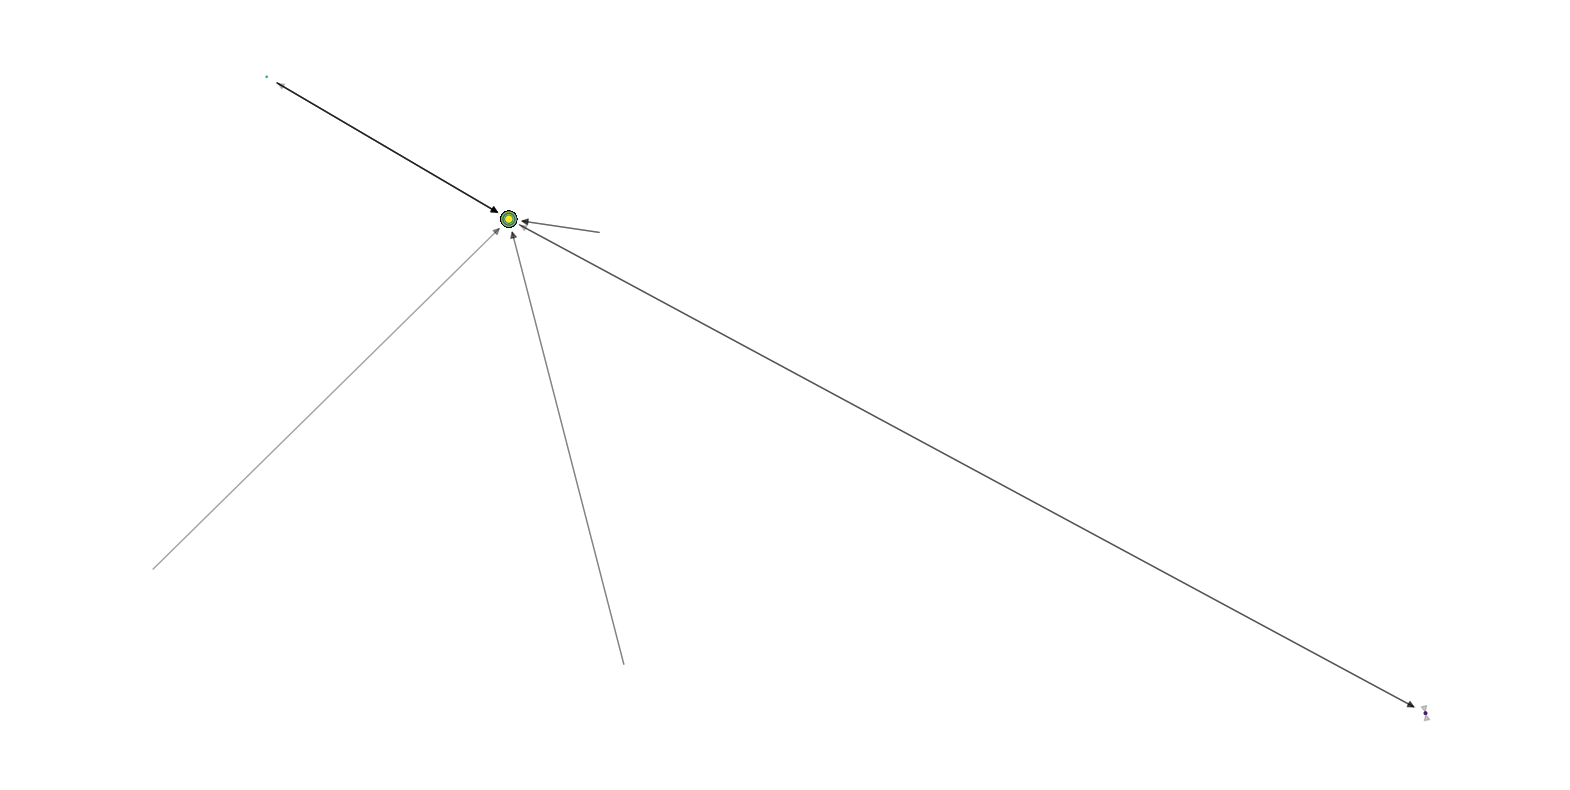

In [36]:
plt.figure(figsize=(20,10))

nx.draw_networkx_nodes(G, pos=pos_FA, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos_FA, edge_color="black", alpha=0.2)
plt.axis('off')
plt.show()

## Finding communities

In [37]:
communities = community.louvain_communities(G)

In [38]:
len(communities)

45

In [39]:
c_list_communities = []
for i in G.nodes():
    for j in range(len(communities)):
        if G.nodes()[i].get("data").name in communities[j]:
            c_list_communities.append(j+1)

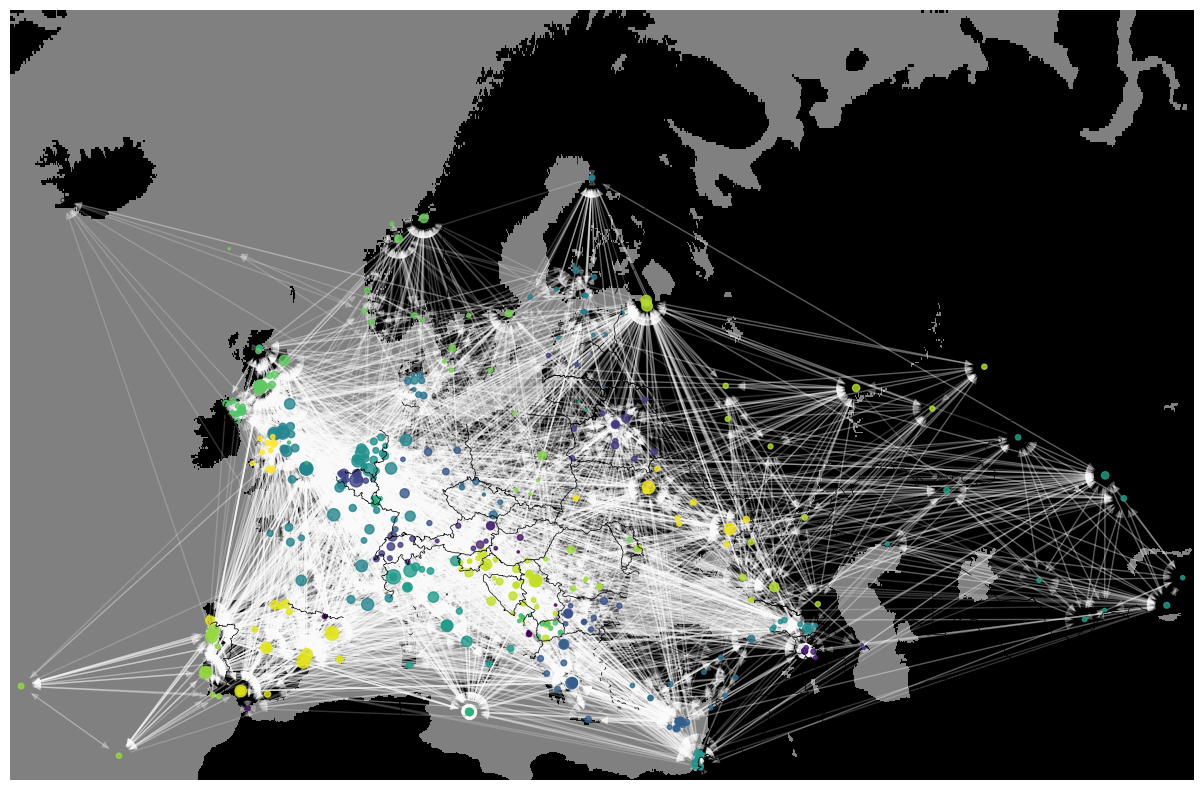

In [40]:
plt.figure(figsize=(20,10))

m = Basemap(
        projection='merc',
        llcrnrlon=df_team_loc.lon.min()-1,
        llcrnrlat=df_team_loc.lat.min()-1,
        urcrnrlon=df_team_loc.lon.max()+1,
        urcrnrlat=df_team_loc.lat.max()+1,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_team_loc.lon,df_team_loc.lat)
df_team_loc["mx"], df_team_loc["my"] = mx, my
pos = df_team_loc.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G, pos=pos, node_size=np.array(list(dict(G.in_degree()).values())), cmap=cmap, node_color=c_list_communities, alpha=0.8)
nx.draw_networkx_edges(G, pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

Comparing with the normal graph plot it seems very similar

# Getting league placement for specific leagues

In [41]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/asger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
seasons = [(i - 1, i) for i in range(2005, 2022)] 

In [43]:
leagues = {
        'England': 'https://www.worldfootball.net/schedule/eng-premier-league-year1-year2-spieltag/38/',
        'Italy': 'https://www.worldfootball.net/schedule/ita-serie-a-year1-year2-spieltag/38/',
        'Spain': 'https://www.worldfootball.net/schedule/esp-primera-division-year1-year2-spieltag/38/', 
        'France': 'https://www.worldfootball.net/schedule/fra-ligue-1-year1-year2-spieltag/38/'
    }

In [44]:
tables = []

for season in seasons:
    for country, url in leagues.items():
        table = get_table(season, country, url)
        if table is not None:
            tables.append(table)

In [155]:
df_league = pd.concat(tables)

In [156]:
df_league = df_league.drop(columns = 'Team').rename(columns={'#': 'Placement', 'Team.1':'Team', 'Pt.':'Points'})

In [157]:
teams_in_graph = list(G.nodes())

In [158]:
df_league['converted_team_name'] = df_league.apply(lambda x: process.extractOne(x.Team, teams_in_graph, score_cutoff=90), axis=1)

In [165]:
df_league['converted_team_name'] = df_league.apply(lambda x: x.converted_team_name[0] if x.converted_team_name is not None else None, axis=1)

In [166]:
G.in_degree()[df_league.converted_team_name.iloc[0]]

89

In [169]:
df_league['in_degree'] = df_league.apply(lambda x: G.in_degree()[x['converted_team_name']] if x['converted_team_name'] is not None else None, axis = 1)

In [170]:
df_league['goals_conceded'] = df_league.apply(lambda x: int(x.goals.split(':')[1]), axis=1)
df_league['goals_scored'] = df_league.apply(lambda x: int(x.goals.split(':')[0]), axis=1)

In [171]:
df_league.groupby(['country', 'Team']).agg({'goals_conceded':'mean'}).sort_values('goals_conceded', ascending = True)

goals_conceded
country Team                               
Italy   Juventus                  31.312500
Spain   FC Barcelona              32.062500
England Chelsea FC                33.705882
France  Paris Saint-Germain       33.882353
England Manchester United         34.117647
...                                     ...
Spain   CD Tenerife               74.000000
England Blackpool FC              78.000000
Italy   Benevento Calcio          79.500000
        Pescara Calcio            82.500000
England Derby County              89.000000

[161 rows x 1 columns]

In [172]:
mean_placement = df_league.groupby(['Team','country']).agg({'in_degree':'mean', 'Placement':'mean', 'Points':'mean', 'Dif.':'mean', 'goals_scored':'mean', 'converted_team_name':'first'})

In [173]:
mean_placement = mean_placement.reset_index()

# Fitting Linear Regression from in-degree

In [179]:
df_england = mean_placement[mean_placement['country'] == 'England'].dropna()
df_italy = mean_placement[mean_placement['country'] == 'Italy'].dropna()
df_spain = mean_placement[mean_placement['country'] == 'Spain'].dropna()

In [180]:
lr_england, res_england = fit_ols(df_england)
lr_italy, res_italy = fit_ols(df_italy)
lr_spain, res_spain = fit_ols(df_spain)

In [181]:
variance_explained_england = round(res_england.rsquared,2)
variance_explained_italy = round(res_italy.rsquared,2)
variance_explained_spain = round(res_spain.rsquared,2)

In [183]:
res_england.summary()

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Placement   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     32.08
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           2.80e-05
Time:                        16:21:27   Log-Likelihood:                -44.559
No. Observations:                  19   AIC:                             93.12
Df Residuals:                      17   BIC:                             95.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9301      1.423     11.898      0.000      13.928      19.932
in_degree     -0.1400      0.025     -5.664      0.000      -0.192      -0.088
==============================================================================
Omnibus:                        0.246   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.884   Jarque-Bera (JB):                0.432
Skew:                          -0.019   Prob(JB):                        0.806
Kurtosis:                       2.263   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
res_italy.summary()

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Placement   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     4.522
Date:                Tue, 13 Dec 2022   Prob (F-statistic):             0.0594
Time:                        16:21:30   Log-Likelihood:                -32.361
No. Observations:                  12   AIC:                             68.72
Df Residuals:                      10   BIC:                             69.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.0789      1.970      7.145      0.000       9.689      18.469
in_degree     -0.0965      0.045     -2.126      0.059      -0.198       0.005
==============================================================================
Omnibus:                       10.210   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                5.508
Skew:                          -1.151   Prob(JB):                       0.0637
Kurtosis:                       5.391   Cond. No.                         75.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
res_spain.summary()

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Placement   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     66.69
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.78e-06
Time:                        16:21:36   Log-Likelihood:                -29.994
No. Observations:                  15   AIC:                             63.99
Df Residuals:                      13   BIC:                             65.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.1903      0.913     17.732      0.000      14.218      18.163
in_degree     -0.1482      0.018     -8.167      0.000      -0.187      -0.109
==============================================================================
Omnibus:                        6.895   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                3.772
Skew:                          -0.777   Prob(JB):                        0.152
Kurtosis:                       4.903   Cond. No.                         92.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot

In [188]:
def plot_prediction(df, res, title, ax):
    ax.plot(df.in_degree, res.get_prediction(df.in_degree).summary_frame(alpha = 0.05)[['mean']], color = 'red', label = f'Fitted Model - $R^2$ = {np.round(res.rsquared,2)}')
    ax.plot(df.in_degree.sort_values(), res.get_prediction(df.in_degree.sort_values()).summary_frame(alpha = 0.05)[['mean_ci_lower']], color = 'b', linestyle = '--')
    ax.plot(df.in_degree.sort_values(), res.get_prediction(df.in_degree.sort_values()).summary_frame(alpha = 0.05)[['mean_ci_upper']], color = 'b', linestyle = '--')
    ax.fill_between(df.in_degree.sort_values(),res.get_prediction(df.in_degree.sort_values()).summary_frame(alpha = 0.05)['mean_ci_lower'], res.get_prediction(df.in_degree.sort_values()).summary_frame(alpha = 0.05)['mean_ci_upper'], alpha = 0.15, label = '95% CI')
    ax.scatter(df.in_degree, df.Placement, label = 'Observations', color = 'k')
    ax.set_title(title)
    ax.set_xlabel('In degree')
    ax.set_ylabel('Average Placement')
    ax.legend()

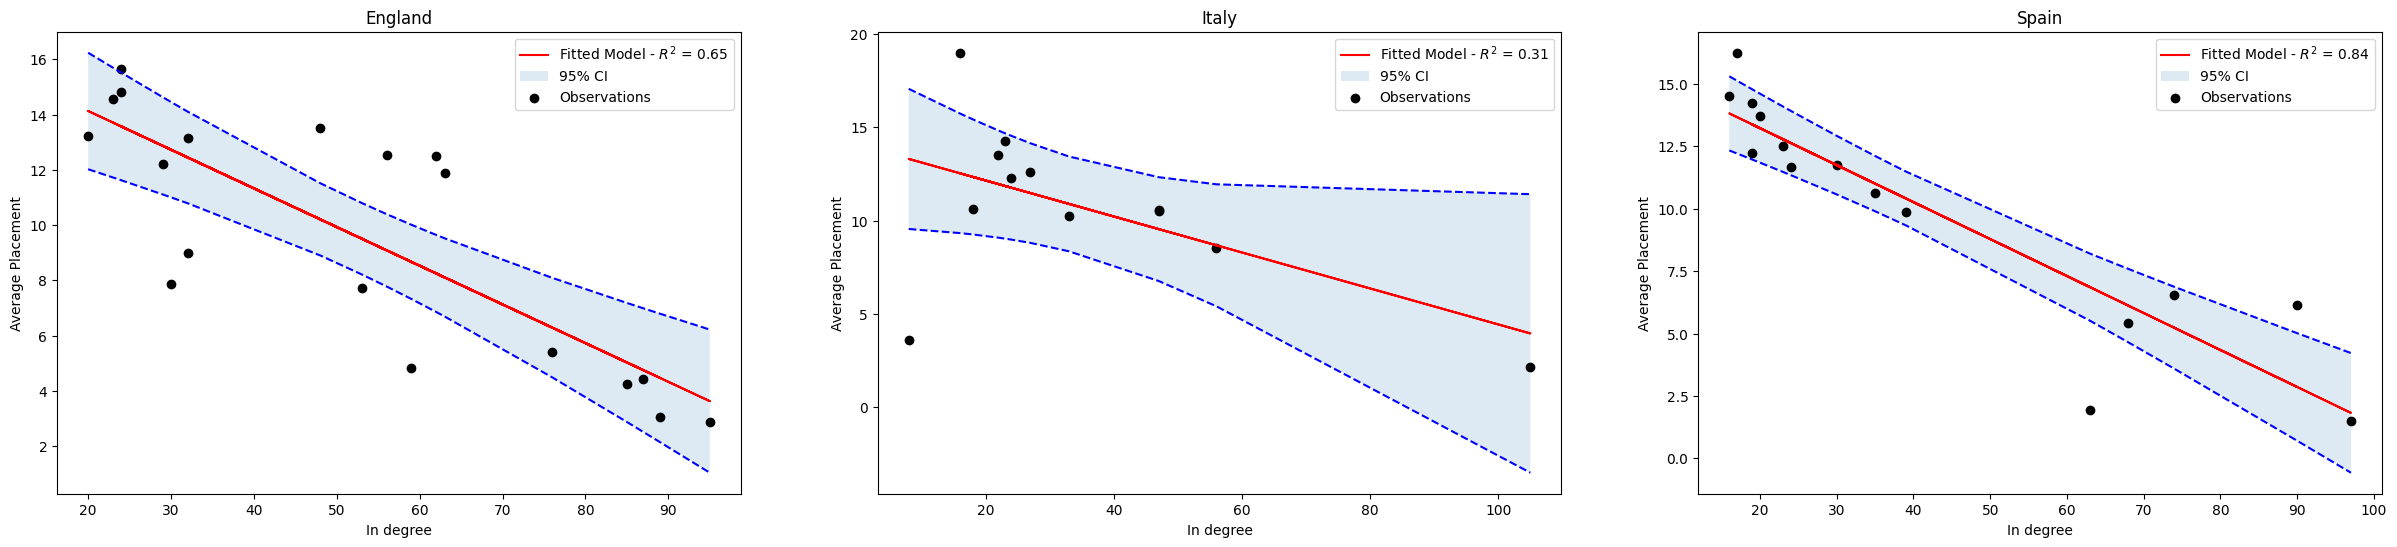

In [189]:
fig, ax = plt.subplots(1,3, figsize = (30, 6))
plot_prediction(df_england, res_england, 'England', ax[0])
plot_prediction(df_italy, res_italy, 'Italy', ax[1])
plot_prediction(df_spain, res_spain, 'Spain', ax[2])

# Fitting Linear Regression as function of sentiment

In [190]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/asger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
corpuses = {}

for club in G.nodes():
    club_data = G.nodes()[club].get('data')
    if club_data.country == 'England':
        corpus = [w for w in club_data.words if w not in stopwords]
        corpuses[club_data.name] = corpus

In [192]:
sentiment_words = pd.read_csv('data/Data_Set_S1.csv')

Selecting interesting words for the purpose of predicting league placement 

In [193]:
words_of_interest  = [
    "win",
    "won",
    "champion",
    "lose",
    "loss",
    "lost",
    "concede",
    "first",
    "success",
    "successful",
    "successfully",
    "trophy",
    "trophies",
    "beaten",
    "beat",
    "lowest",
]

In [194]:
chosen_words_sentiment = sentiment_words[sentiment_words.word.isin(words_of_interest)]

In [195]:
sentiment_dict = dict(zip(chosen_words_sentiment.word, chosen_words_sentiment.happiness_average))

In [196]:
sentiment_dict['relegation'] = 2.0
sentiment_dict['relegate'] = 2.0
sentiment_dict['winless'] = 1.0
sentiment_dict['trophy'] = 7.0

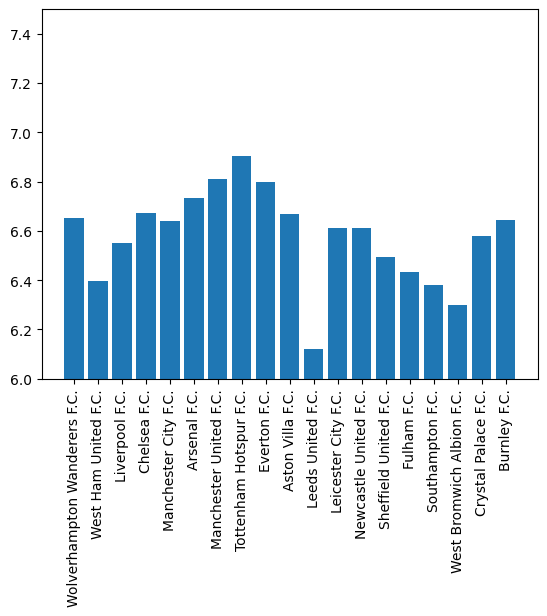

R2 = 0.22929515406866707
Coef = [-0.47884774]
Intercept = 3.5902212614851243e-16


/tmp/ipykernel_12299/1517019409.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")


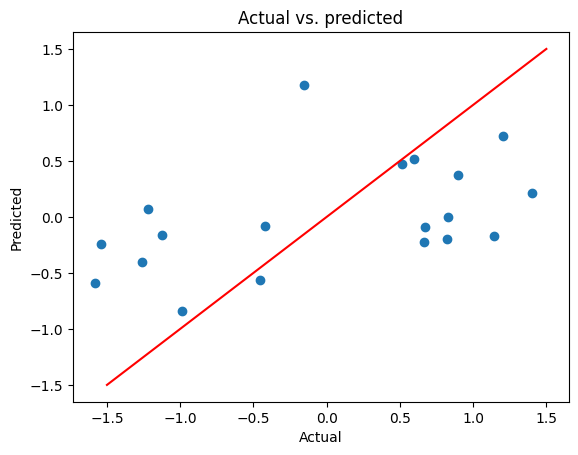

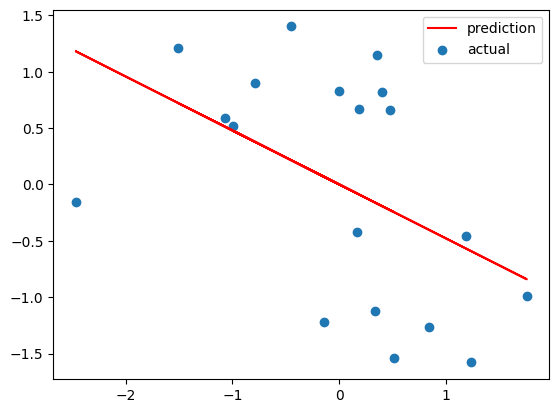

In [197]:
get_sentiment_stats()

In [206]:
sentiment_df = pd.DataFrame(dict(zip(corpuses.keys(),list(map(get_sentiment, corpuses.values())))), index = [0]).T.reset_index()
sentiment_df.columns = ["Team", "SentimentScore"]
sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")
sentiment_df.Team = sentiment_df.Team.str.replace(" ", "")


df_england.Team = df_england.Team.str.replace("FC", "")
df_england.Team = df_england.Team.str.replace(" ", "")

df_sentiment_regression = pd.merge(sentiment_df, df_england, right_on="Team", left_on="Team")[['Team', 'SentimentScore', "Placement"]]

sc = StandardScaler()
data = sc.fit_transform(df_sentiment_regression[['SentimentScore', "Placement"]]).T
data = pd.DataFrame(data.T, columns = ['sentiment_score', 'placement'])
# X, y = data[0], data[1]
lr_sentiment = OLS.from_formula('placement ~ sentiment_score', data=data)
lr_res = lr_sentiment.fit()

/tmp/ipykernel_12299/1096797558.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")


In [207]:
X = df_sentiment_regression['SentimentScore']
y = df_sentiment_regression['Placement']
y_hat_mean = (lr_res.get_prediction(data[['sentiment_score']].sort_values('sentiment_score')).summary_frame(alpha = 0.05)[['mean']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]
y_hat_low = (lr_res.get_prediction(data[['sentiment_score']].sort_values('sentiment_score')).summary_frame(alpha = 0.05)[['mean_ci_lower']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]
y_hat_high = (lr_res.get_prediction(data[['sentiment_score']].sort_values('sentiment_score')).summary_frame(alpha = 0.05)[['mean_ci_upper']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]

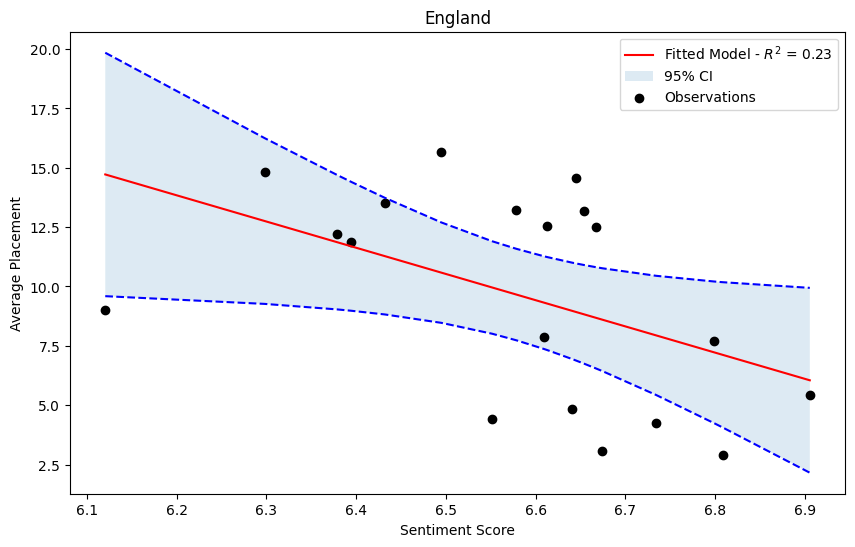

In [208]:
plt.figure(figsize = (10, 6))
plt.plot(X.sort_values(), y_hat_low, color = 'b', linestyle = '--')
plt.plot(X.sort_values(), y_hat_mean, color = 'red', label = f'Fitted Model - $R^2$ = {np.round(lr_res.rsquared,2)}')
plt.plot(X.sort_values(), y_hat_high, color = 'b', linestyle = '--')
plt.fill_between(X.sort_values(), y_hat_low, y_hat_high, alpha = 0.15, label = '95% CI')
plt.scatter(X, y, label = 'Observations', color = 'k')
plt.title('England')
plt.xlabel('Sentiment Score')
plt.ylabel('Average Placement')
plt.legend()
plt.show()

In [210]:
lr_res.summary()

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     5.058
Date:                Tue, 13 Dec 2022   Prob (F-statistic):             0.0381
Time:                        16:25:17   Log-Likelihood:                -24.486
No. Observations:                  19   AIC:                             52.97
Df Residuals:                      17   BIC:                             54.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.829e-16      0.213  -2.74e-15      1.000      -0.449       0.449
sentiment_score    -0.4788      0.213     -2.249      0.038      -0.928      -0.030
==============================================================================
Omnibus:                        4.549   Durbin-Watson:                   0.867
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                1.529
Skew:                          -0.178   Prob(JB):                        0.466
Kurtosis:                       1.657   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [201]:
sentiment_df = pd.DataFrame(dict(zip(corpuses.keys(),list(map(get_sentiment, corpuses.values())))), index = [0]).T.reset_index()
sentiment_df.columns = ["Team", "SentimentScore"]
sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")
sentiment_df.Team = sentiment_df.Team.str.replace(" ", "")


df_england.Team = df_england.Team.str.replace("FC", "")
df_england.Team = df_england.Team.str.replace(" ", "")

df_sentiment_regression = pd.merge(sentiment_df, df_england, right_on="Team", left_on="Team")[['Team', 'SentimentScore', "Placement", "in_degree"]]

sc = StandardScaler()
data = sc.fit_transform(df_sentiment_regression[['SentimentScore', "Placement", "in_degree"]]).T
data = pd.DataFrame(data.T, columns = ['sentiment_score', 'placement', "in_degree"])
# X, y = data[0], data[1]
lr_sentiment = OLS.from_formula('placement ~ sentiment_score + in_degree', data=data)
lr_res = lr_sentiment.fit()

/tmp/ipykernel_12299/657138491.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_df.Team = sentiment_df.Team.str.replace("F.C.", "")


In [202]:
X = df_sentiment_regression['in_degree']
y = df_sentiment_regression['Placement']
y_hat_mean = (lr_res.get_prediction(data[['sentiment_score', 'in_degree']].sort_values('in_degree')).summary_frame(alpha = 0.05)[['mean']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]
y_hat_low = (lr_res.get_prediction(data[['sentiment_score', 'in_degree']].sort_values('in_degree')).summary_frame(alpha = 0.05)[['mean_ci_lower']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]
y_hat_high = (lr_res.get_prediction(data[['sentiment_score', 'in_degree']].sort_values('in_degree')).summary_frame(alpha = 0.05)[['mean_ci_upper']] * np.sqrt(sc.var_[1]) + sc.mean_[1]).values.reshape(1,-1)[0]

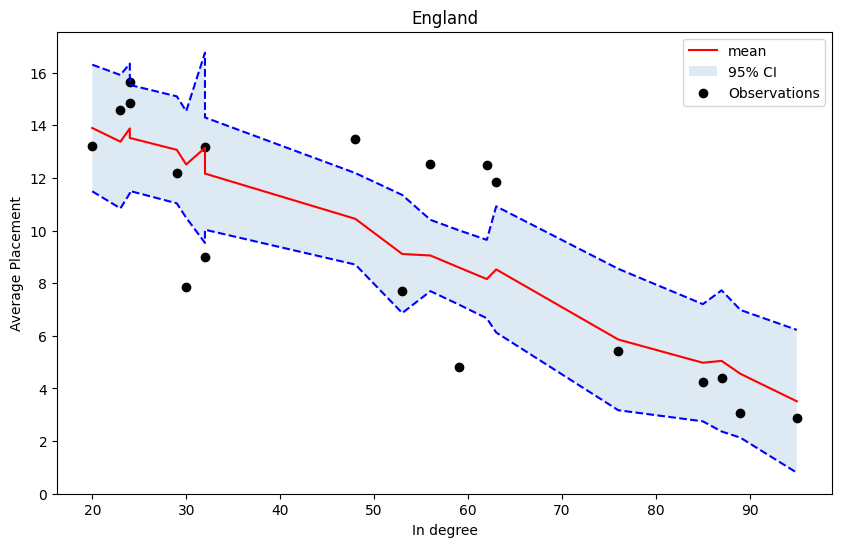

In [204]:
plt.figure(figsize = (10, 6))
plt.plot(X.sort_values(), y_hat_low, color = 'b', linestyle = '--')
plt.plot(X.sort_values(), y_hat_mean, color = 'red', label = 'mean')
plt.plot(X.sort_values(), y_hat_high, color = 'b', linestyle = '--')
plt.fill_between(X.sort_values(), y_hat_low, y_hat_high, alpha = 0.15, label = '95% CI')
plt.scatter(X, y, label = 'Observations', color = 'k')
plt.title('England')
plt.xlabel('In degree')
plt.ylabel('Average Placement')
plt.legend()
plt.show()

In [205]:
lr_res.summary()

/home/asger/.cache/pypoetry/virtualenvs/finalproject-MKew1FJg-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              placement   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     15.41
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           0.000186
Time:                        16:22:28   Log-Likelihood:                -16.759
No. Observations:                  19   AIC:                             39.52
Df Residuals:                      16   BIC:                             42.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.829e-16      0.146  -3.99e-15      1.000      -0.310       0.310
sentiment_score    -0.0796      0.171     -0.465      0.648      -0.442       0.283
in_degree          -0.7671      0.171     -4.482      0.000      -1.130      -0.404
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.438
Skew:                          -0.105   Prob(JB):                        0.803
Kurtosis:                       2.287   Cond. No.                         1.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# England specific Graph plot

In [77]:
df_england = df_team_loc[(df_team_loc.iso == "GB") & (df_team_loc.ID <= 100)]

## Plotting

/tmp/ipykernel_12299/2756456390.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_england["mx"], df_england["my"] = mx, my


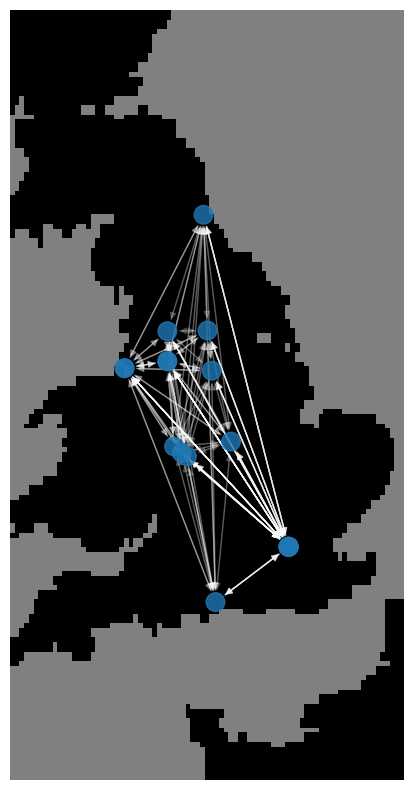

In [78]:
plt.figure(figsize=(20,10))


m = Basemap(
        projection='merc',
        llcrnrlon=df_england.lon.min()-2,
        llcrnrlat=df_england.lat.min()-2,
        urcrnrlon=df_england.lon.max()+2,
        urcrnrlat=df_england.lat.max()+2,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx,my=m(df_england.lon,df_england.lat)
df_england["mx"], df_england["my"] = mx, my
pos = df_england.set_index("TeamName").apply(lambda x: [x.mx, x.my], axis=1).to_dict()

nx.draw_networkx_nodes(G.subgraph(df_england.TeamName.values), pos=pos, node_size=10*np.array(list(dict(G.subgraph(df_england.TeamName.values).in_degree()).values())), alpha=0.8)
nx.draw_networkx_edges(G.subgraph(df_england.TeamName.values), pos=pos, edge_color="white", alpha=0.2)
plt.axis('off')

m.drawcountries()
m.drawstates()
m.drawlsmask(land_color='black',ocean_color='grey',lakes=True)

plt.show()

# Word cloud

In [79]:
from nltk.corpus import stopwords

In [80]:
nltk.download('stopwords')
stopwords = list(stopwords.words('english')) + ["club", "season", "page", "article"]

[nltk_data] Downloading package stopwords to /home/asger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
def get_wordcloud(corpus, ax, country):
    tfidf = TfidfVectorizer(stop_words=stopwords)
    X = tfidf.fit_transform(corpus)
    word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    word2tfidf=dict(sorted(word2tfidf.items(), key=lambda item: item[1]))
    wc = wordcloud.WordCloud().generate(' '.join(word2tfidf))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(country)

In [82]:
# eng_dict = {}
# for i in dict(G.nodes()).keys():
#     if G.nodes()[i].get("data").country == "England":
#         eng_dict[G.nodes()[i].get("data").name] = G.nodes()[i].get("data").words

In [83]:
league_dict = {}
league_corpus = []
for i in dict(G.nodes()).keys():
    if not league_dict.get(G.nodes()[i].get("data").country):
        league_dict[G.nodes()[i].get("data").country] = []
    league_dict.get(G.nodes()[i].get("data").country).append(G.nodes()[i].get("data").words)

In [84]:
league_df = pd.DataFrame.from_dict(league_dict, orient="index").apply(lambda x: [x[i] for i in range(19) if x[i] is not None], axis=1).reset_index()

In [85]:
league_df["corpus"] = 0 
for i in range(league_df.shape[0]):
    league_df["corpus"].iloc[i] = [' '.join(item) for item in league_df[0][i]]

/tmp/ipykernel_12299/2836351621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df["corpus"].iloc[i] = [' '.join(item) for item in league_df[0][i]]


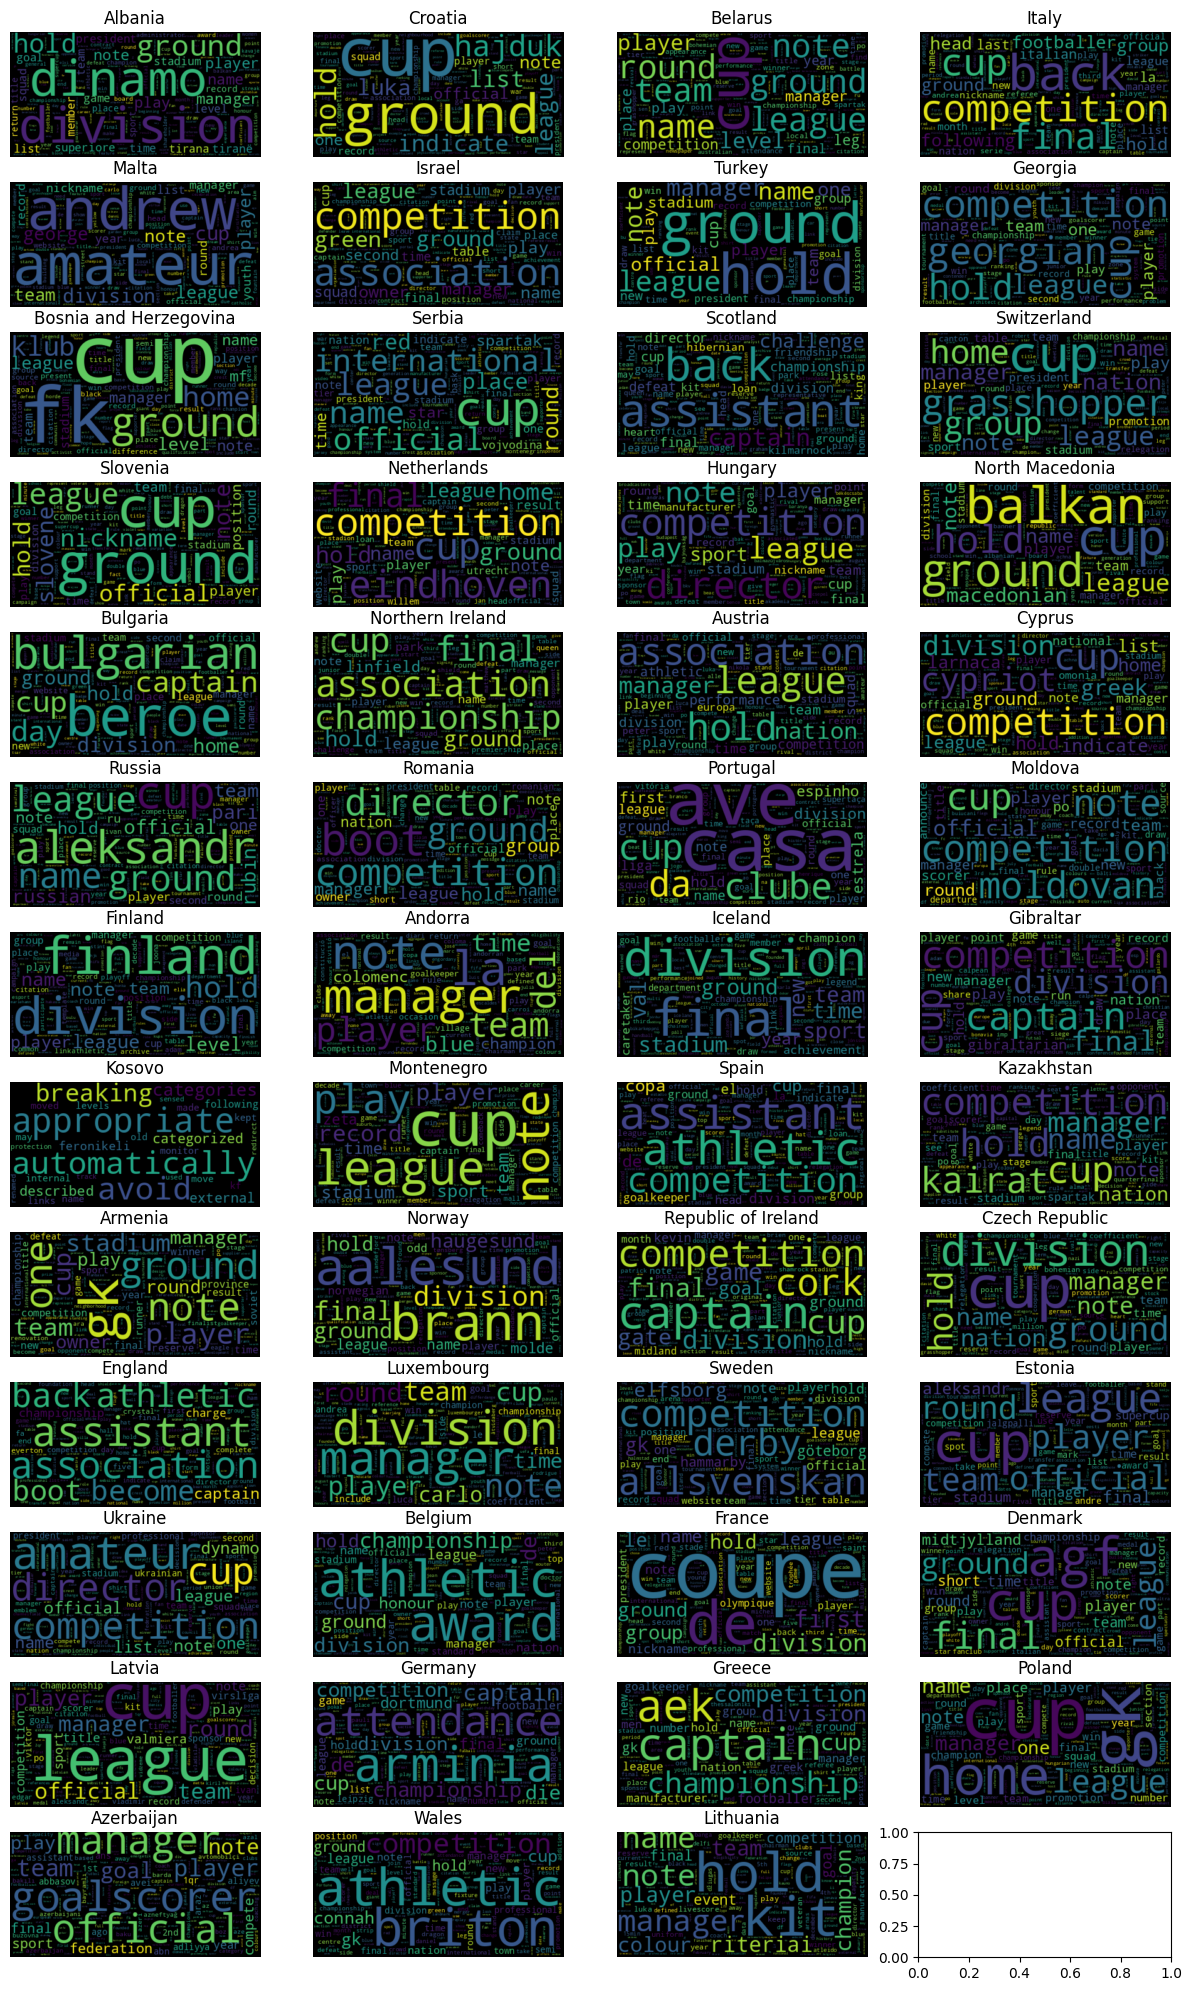

In [86]:
fig, ax = plt.subplots(13,4, figsize = (15, 25))
ax = ax.ravel()
for idx, row in league_df.iterrows():
    try:
        get_wordcloud(row["corpus"], ax[idx], row["index"])
    except ValueError:
        continue
plt.show()

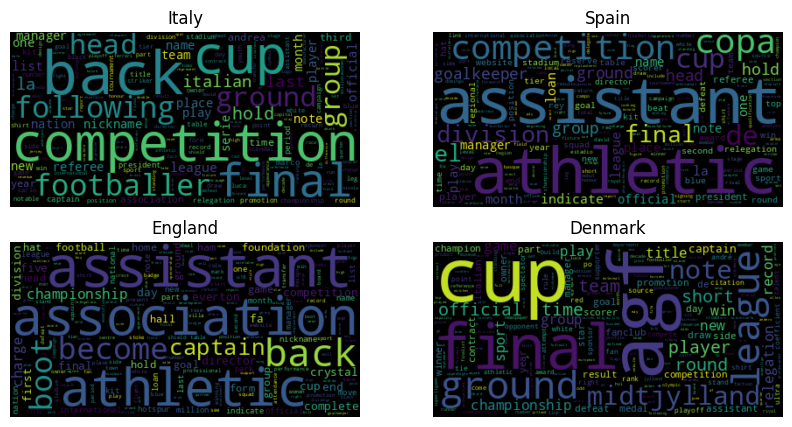

In [87]:
fig, ax = plt.subplots(2,2, figsize = (10, 5))
ax = ax.ravel()
temp_df = league_df.rename(columns= {"index":"country", "0":"0", "corpus":"corpus"})
for idx, row in temp_df[temp_df.country.isin(["England", "Italy", "Spain", "Denmark"])].reset_index().drop(columns=["index"]).iterrows():
    get_wordcloud(row["corpus"], ax[idx], row["country"])
plt.show()